In [1]:
%matplotlib inline

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from numpy.random import Generator, MT19937

# Load an image

In [3]:
# img = np.fromfile("../examples/tennis0_2048x1365.raw", dtype=np.uint8).reshape(1365, 2048)
# img = np.fromfile("../examples/tennis1_2440x1372.raw", dtype=np.uint8).reshape(1372, 1372)
# img = np.fromfile("../examples/tennis2_3000x2002.raw", dtype=np.uint8).reshape(2002, 3000)
# img = np.fromfile("../examples/tennis3_1000x563.raw", dtype=np.uint8).reshape(563, 1000)
# img = np.fromfile("../examples/tennis4_1000x563.raw", dtype=np.uint8).reshape(563, 1000)
# img = np.fromfile("../examples/tennis5_2440x1373.raw", dtype=np.uint8).reshape(1373, 2440)
# img = np.fromfile("../examples/tennis6_2440x1372.raw", dtype=np.uint8).reshape(1372, 2440)
# img = np.fromfile("../examples/tennis7_602x389.raw", dtype=np.uint8).reshape(389, 602)
img = np.fromfile("../examples/image_1392x550.raw", dtype=np.uint8).reshape(550, 1392)

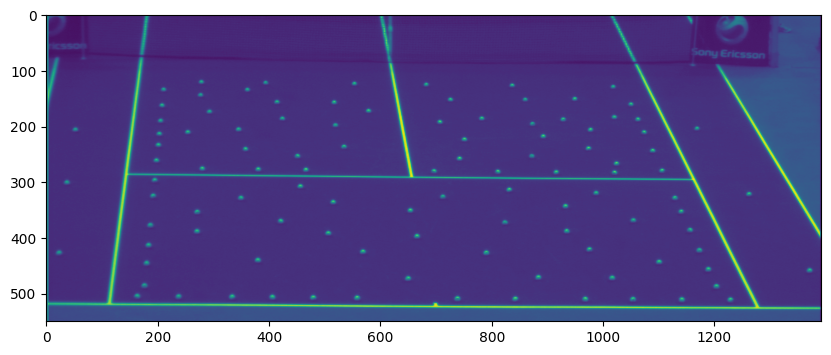

In [4]:
plt.figure(figsize=(10,5))
plt.imshow(img)
plt.show()

### Assume some line width (in pixels)

In [5]:
line_width = 10

# Detect line pixels

### Consider 5% of the brightest pixels as "bright"

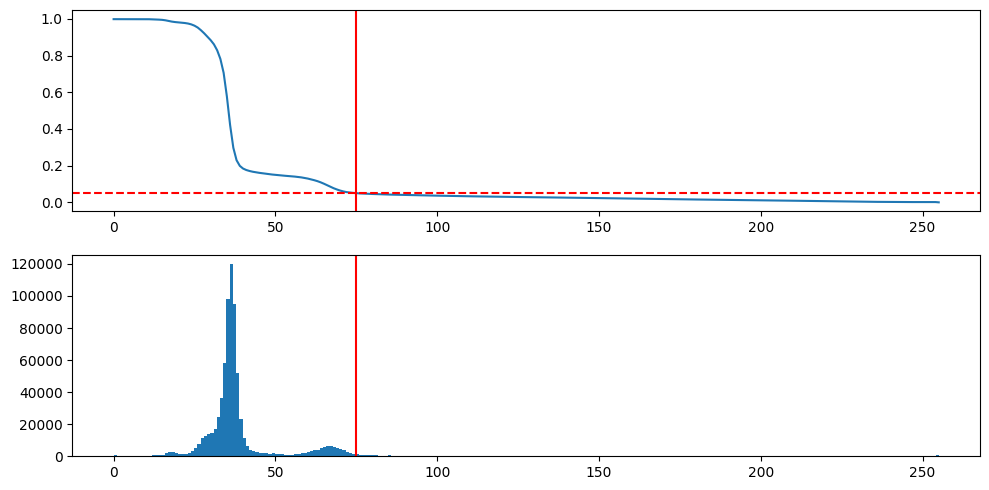

In [6]:
dist_thr = 0.05
max_bright_thr = 220

intensity_dist = np.array(list(map(lambda thr: cv.countNonZero(cv.threshold(img, thr, 255, cv.THRESH_BINARY)[1]) / img.size, range(256))))
bright_thr = np.argmax(intensity_dist < dist_thr)
bright_thr = min(bright_thr, max_bright_thr)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), tight_layout=True)

ax1.plot(intensity_dist)
ax1.axvline(x=bright_thr, color='r')
ax1.axhline(y=dist_thr, color='r', linestyle='--')

ax2.hist(img.reshape(-1), bins=256)
ax2.axvline(x=bright_thr, color='r')

plt.show()

### Extract bright pixels

Threshold used:  75


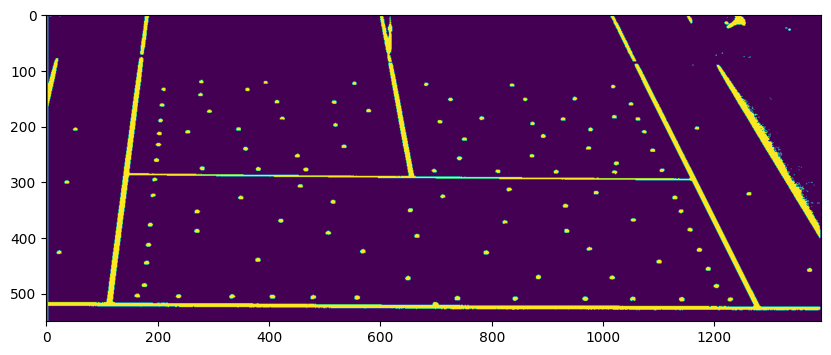

In [7]:
print("Threshold used: ", bright_thr)
_, bright_pixels = cv.threshold(img, bright_thr, 1, cv.THRESH_BINARY)
plt.figure(figsize=(10,5))
plt.imshow(bright_pixels)
plt.show()

### Extract dark pixels

Threshold used:  72


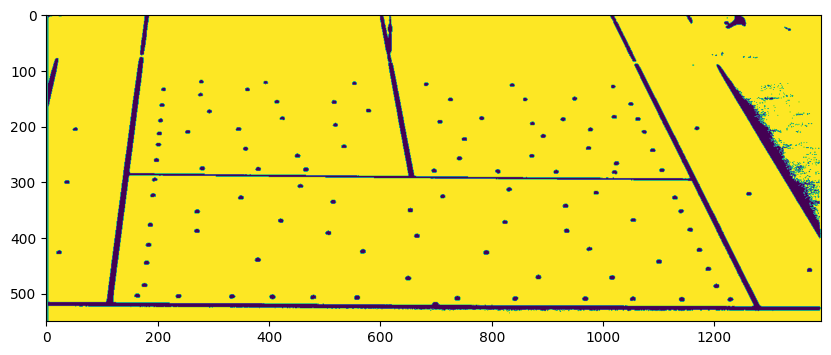

In [8]:
dark_thr = bright_thr - 3
print("Threshold used: ", dark_thr)
_, dark_pixels = cv.threshold(img, dark_thr, 1, cv.THRESH_BINARY_INV)
plt.figure(figsize=(10,5))
plt.imshow(dark_pixels)
plt.show()

### Bright pixels should be brighter than their neighbours

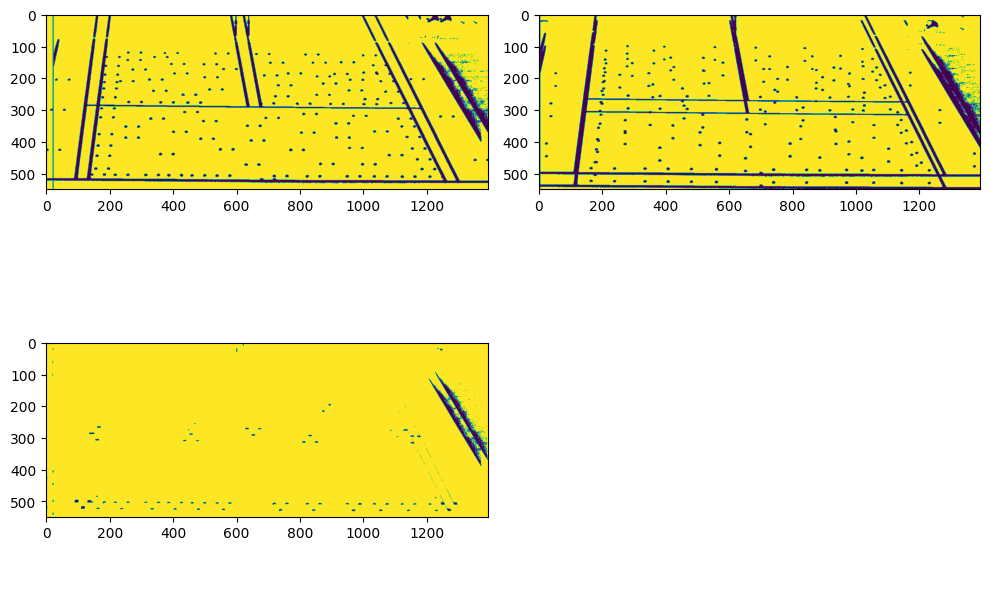

In [9]:
neighbour_dist = 2 * line_width

has_dark_horizontal_neighbourhood = np.ones(img.shape, dtype=img.dtype)
has_dark_horizontal_neighbourhood[:,neighbour_dist:] *= dark_pixels[:, :-neighbour_dist]
has_dark_horizontal_neighbourhood[:,:-neighbour_dist] *= dark_pixels[:, neighbour_dist:]

has_dark_vertical_neighbourhood = np.ones(img.shape, dtype=img.dtype)
has_dark_vertical_neighbourhood[neighbour_dist:,:] *= dark_pixels[:-neighbour_dist,:]
has_dark_vertical_neighbourhood[:-neighbour_dist,:] *= dark_pixels[neighbour_dist:,:]

has_dark_neighbourhood = has_dark_horizontal_neighbourhood | has_dark_vertical_neighbourhood

fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(10, 7), tight_layout=True)
ax11.imshow(has_dark_horizontal_neighbourhood)
ax12.imshow(has_dark_vertical_neighbourhood)
ax21.imshow(has_dark_neighbourhood)
ax22.axis('off')
plt.show()

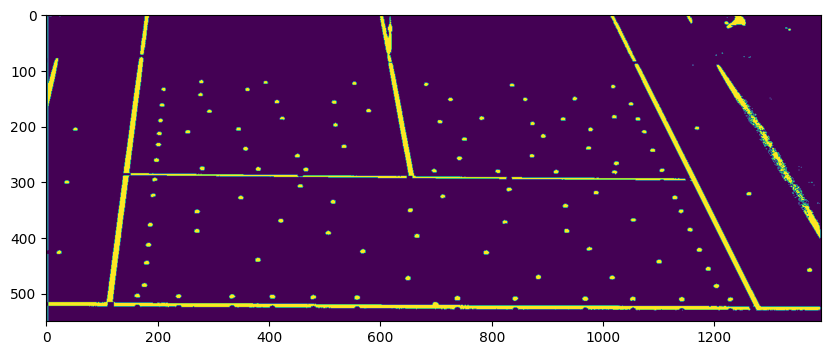

In [10]:
plt.figure(figsize=(10,5))
plt.imshow(bright_pixels & has_dark_neighbourhood)
plt.show()

### Extract line features
By calculating the eigenvalues of covariance matrix of jacobian of pixel neighbourhood... like in Shi-Thomasi corner detector, but take lines instead.

This means that $\lambda_1$ must be big and $\lambda_1 \gg \lambda_2$

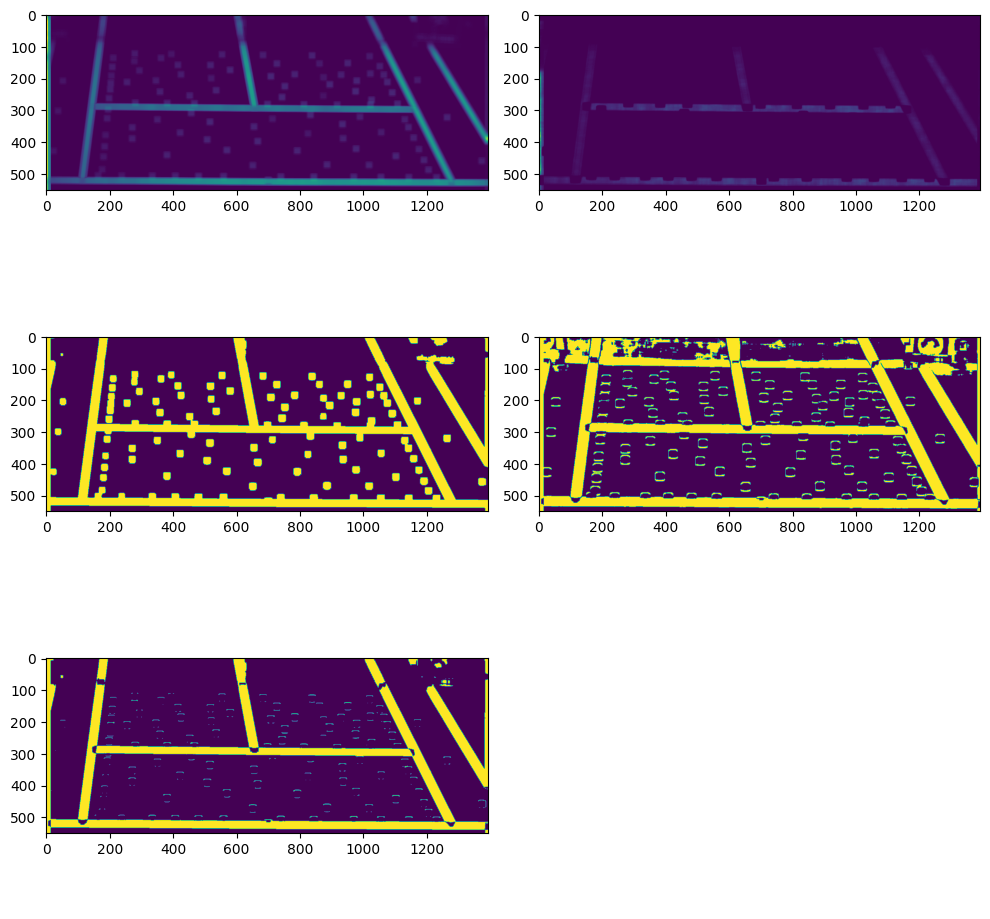

In [11]:
eigenvals = cv.cornerEigenValsAndVecs(img, neighbour_dist, 3)[:,:,:2]
first_eigenval_thr = 0.002
eigenval_ratio_thr = 4.
first_eigenval = eigenvals[:,:,0]
eigenval_ratio = eigenvals[:,:,0] / eigenvals[:,:,1]

fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32)) = plt.subplots(3, 2, figsize=(10, 10), tight_layout=True)
ax11.imshow(first_eigenval)
ax12.imshow(eigenval_ratio)
ax21.imshow(first_eigenval > first_eigenval_thr)
ax22.imshow(eigenval_ratio > eigenval_ratio_thr)

has_line_features = (first_eigenval > first_eigenval_thr) & (eigenvals[:,:,0] > eigenval_ratio_thr * eigenvals[:,:,1])
ax31.imshow(has_line_features)
ax32.axis('off')
plt.show()

### Result

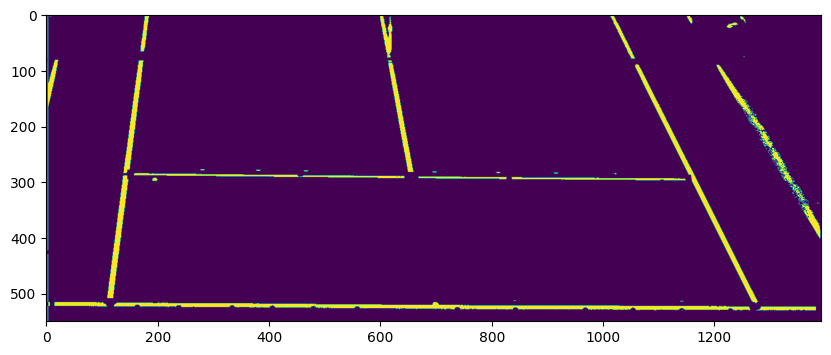

In [12]:
line_pixels_img = bright_pixels & has_dark_neighbourhood & has_line_features
plt.figure(figsize=(10,5))
plt.imshow(line_pixels_img)
plt.show()

In [13]:
line_pixels_in_image = np.transpose(line_pixels_img.nonzero())[:,::-1].astype(float).T
line_pixels_in_image = np.vstack([line_pixels_in_image, np.ones(line_pixels_in_image.shape[1])])

print(line_pixels_in_image.shape)
line_pixels_in_image

(3, 29704)


array([[  7.,   8.,   9., ...,   3.,   1.,   3.],
       [  0.,   0.,   0., ..., 548., 549., 549.],
       [  1.,   1.,   1., ...,   1.,   1.,   1.]])

### Fake some camera matrix and convert the line pixel coordinates to homogenous space

In [14]:
# Fake some camera matrix
cx = img.shape[1] / 2
cy = img.shape[0] / 2
f = (cx + cy) * 2
cam_mat = np.array([
    [f,  0., cx],
    [0., f,  cy],
    [0., 0., 1.]
])
cam_mat_inv = np.linalg.inv(cam_mat)
cam_mat

array([[1.942e+03, 0.000e+00, 6.960e+02],
       [0.000e+00, 1.942e+03, 2.750e+02],
       [0.000e+00, 0.000e+00, 1.000e+00]])

In [15]:
line_pixels_in_camera = cam_mat_inv @ line_pixels_in_image
line_pixels_in_camera

array([[-0.35478888, -0.35427394, -0.35375901, ..., -0.35684861,
        -0.35787848, -0.35684861],
       [-0.14160659, -0.14160659, -0.14160659, ...,  0.14057673,
         0.14109166,  0.14109166],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [16]:
line_pixels_in_camera_normed = line_pixels_in_camera / np.linalg.norm(line_pixels_in_camera, axis=0)
line_pixels_in_camera_normed

array([[-0.33142969, -0.3310014 , -0.3305729 , ..., -0.33318301,
        -0.33401632, -0.33316195],
       [-0.13228326, -0.13230434, -0.1323254 , ...,  0.13125391,
         0.13168413,  0.13172637],
       [ 0.93416032,  0.93430918,  0.93445789, ...,  0.93368169,
         0.9333233 ,  0.93362266]])

# Detect lines

### Helper functions

In [17]:
def deg2rad(degrees):
    return degrees * np.pi / 180.0
def rad2deg(radians):
    return radians * 180.0 / np.pi

In [18]:
def get_points_on_line(line_in_image, img_shape):
    # We are sure that the line is visible in the image.
    
    # Line at infinity -> display dot in the center of the image
    if line_in_image[0] == 0 and line_in_image[1] == 0: 
        return (
            np.array([img_shape[1] / 2, img_shape[0] / 2]).round().astype(int),
            np.array([img_shape[1] / 2, img_shape[0] / 2]).round().astype(int)
        )
    
    # Line is vertical
    if line_in_image[1] == 0:
        x = -line_in_image[2] / line_in_image[0]
        return (
            np.array([x, 0]).round().astype(int),
            np.array([x, img_shape[0]]).round().astype(int)
        )
    
    # Line is not vertical
    # Let's find the intersection points of a line and a circle defined by the image corners (origin: [p, q], radius r)
    p = img_shape[1]
    q = img_shape[0]
    r2 = p*p + q*q
    
    # We can represent a line in a form y = mx + c
    m = -line_in_image[0] / line_in_image[1]
    c = -line_in_image[2] / line_in_image[1]
    
    # We have to equations:
    # (1) y = mx + c
    # (2) (x - p)^2 + (y - q)^2 = R^2
    # Substitute (1) into (2) to get a quadratic equation Ax^2 + Bx + C = 0
    A = m * m + 1.0;
    B = 2.0 * (m * c - m * q - p);
    C = p * p + q * q + c * c - r2 - 2.0 * c * q;
    
    # Solve the quadratic equation
    # The determinant should be positive, we should have two real intersection points
    det = B * B - 4 * A * C;
    sqrt_det = np.sqrt(det);
    x0 = (-B - sqrt_det) / (2.0 * A);
    x1 = (-B + sqrt_det) / (2.0 * A);
    y0 = m * x0 + c;
    y1 = m * x1 + c;
    
    return (
        np.array([x0, y0]).round().astype(int),
        np.array([x1, y1]).round().astype(int)
    )

In [19]:
def draw_lines(display_img, lines, K, color=lambda _: (255, 0, 0)):
    canvas = cv.cvtColor(display_img, cv.COLOR_GRAY2RGB)
    K_invT = np.linalg.inv(K).T
    for idx, line in lines.iterrows():
        line_in_image = K_invT @ line.camera
        pt0, pt1 = get_points_on_line(line_in_image, display_img.shape)
        cv.line(canvas, pt0, pt1, color(idx), 2, cv.LINE_AA)
        
    return canvas

def display_lines(display_img, lines, K, color=lambda _: (255, 0, 0)):
    canvas = draw_lines(display_img, lines, K, color)

    plt.figure(figsize=(10,5))
    plt.imshow(canvas)
    plt.show()

### Use the Hough Transform (not used, decided to use the probabilistic version)

In [20]:
rho_res = 3
theta_res = deg2rad(0.5)
votes_thr = min(img.shape) // 2

hough_lines = cv.HoughLines(line_pixels_img, rho_res, theta_res, votes_thr).reshape(-1, 2)
hough_lines = pd.DataFrame(hough_lines, columns=['rho', 'theta'])
hough_lines['theta_deg'] = rad2deg(hough_lines.theta)
hough_lines = hough_lines.head(100)
hough_lines

rho     theta   theta_deg
0    516.0  1.579523   90.500000
1    525.0  1.570796   90.000000
2    285.0  1.579523   90.500000
3    513.0  1.588250   90.999992
4   -903.0  2.670354  153.000000
..     ...       ...         ...
95   456.0  1.658063   94.999992
96   594.0  1.509710   86.500000
97   444.0  1.640610   94.000000
98 -1080.0  2.696534  154.500000
99   441.0  1.649336   94.499992

[100 rows x 3 columns]

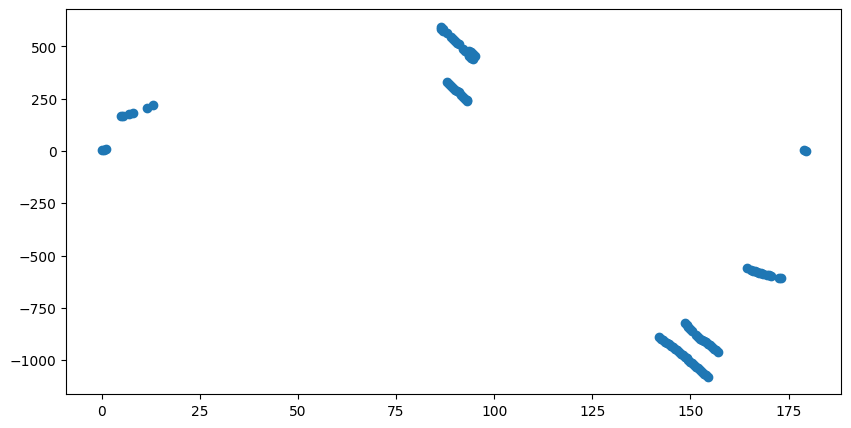

In [21]:
plt.figure(figsize=(10,5))
plt.scatter(hough_lines.theta_deg, hough_lines.rho)
plt.show()

### Calculate line coordinates in camera space

In [22]:
hough_cos_theta, hough_sin_theta = np.cos(hough_lines.theta), np.sin(hough_lines.theta)
hough_lines['camera'] = [cam_mat.T @ np.array([cos_theta, sin_theta, -rho])
                         for cos_theta, sin_theta, rho
                         in zip(hough_cos_theta, hough_sin_theta, hough_lines.rho)]
hough_lines['camera'] = [pt / np.linalg.norm(pt) for pt in hough_lines.camera]

hough_lines

rho     theta   theta_deg  \
0    516.0  1.579523   90.500000   
1    525.0  1.570796   90.000000   
2    285.0  1.579523   90.500000   
3    513.0  1.588250   90.999992   
4   -903.0  2.670354  153.000000   
..     ...       ...         ...   
95   456.0  1.658063   94.999992   
96   594.0  1.509710   86.500000   
97   444.0  1.640610   94.000000   
98 -1080.0  2.696534  154.500000   
99   441.0  1.649336   94.499992   

                                               camera  
0   [-0.008656743780658128, 0.9919652243481202, -0...  
1   [-4.3353630644541383e-08, 0.9918154591693651, ...  
2   [-0.008726230582505642, 0.9999276283109024, -0...  
3   [-0.017309297128212896, 0.9916521964320617, -0...  
4   [-0.8719968200102094, 0.44430467605934426, 0.2...  
..                                                ...  
95  [-0.0864829735472626, 0.9885046603200343, -0.1...  
96  [0.06043670481349366, 0.9881318980813711, -0.1...  
97  [-0.06932020398415098, 0.9913250674792117, -0....  
98  [-0.8660280173650593, 0.4130742017435514, 0.28...  
99  [-0.07795384183710552, 0.9904979720311996, -0....  

[100 rows x 4 columns]

### (optional) Hough Lines Probabilistic version

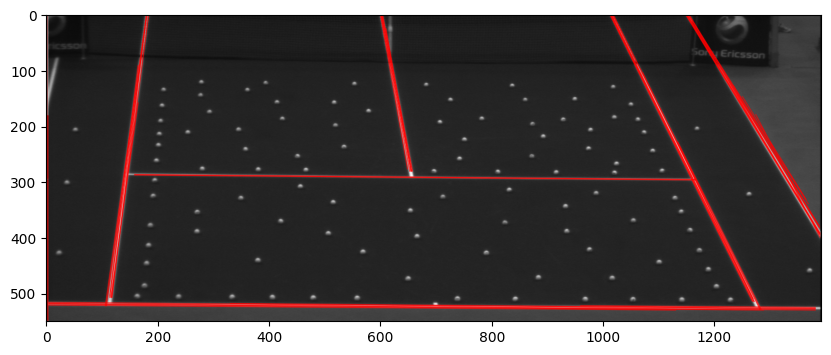

In [23]:
use_hough_prob_version = True
if use_hough_prob_version:
    rho_res = 3
    theta_res = deg2rad(0.5)
    votes_thr = min(img.shape) // 2
    min_line_len = min(img.shape) // 5
    max_line_gap = min(img.shape) // 5
    hough_lines = cv.HoughLinesP(line_pixels_img,
                                 rho_res,
                                 theta_res,
                                 votes_thr,
                                 minLineLength=min_line_len,
                                 maxLineGap=max_line_gap).reshape(-1, 2, 2)

    hough_lines = np.dstack([hough_lines, np.ones((hough_lines.shape[0], hough_lines.shape[1], 1))])

    hough_lines = pd.DataFrame({
        'pt0_in_image': map(lambda pt: pt.reshape(-1), np.vsplit(hough_lines[:, 0, :], hough_lines.shape[0])),
        'pt1_in_image': map(lambda pt: pt.reshape(-1), np.vsplit(hough_lines[:, 1, :], hough_lines.shape[0])) })

    pt0_in_camera = [cam_mat_inv @ pt for pt in hough_lines.pt0_in_image]
    pt1_in_camera = [cam_mat_inv @ pt for pt in hough_lines.pt1_in_image]

    hough_lines['camera'] = [np.cross(pt0, pt1) for pt0, pt1 in zip(pt0_in_camera, pt1_in_camera)]
    hough_lines['camera'] = [pt / np.linalg.norm(pt) for pt in hough_lines.camera]
    
    canvas = cv.cvtColor(img, cv.COLOR_GRAY2RGB)

    for _, line in hough_lines.iterrows():
        cv.line(canvas, line.pt0_in_image[:2].astype(int), line.pt1_in_image[:2].astype(int), (255, 0, 0), 1, cv.LINE_AA)


    plt.figure(figsize=(10,5))
    plt.imshow(canvas)
    plt.show()

### Display detected lines

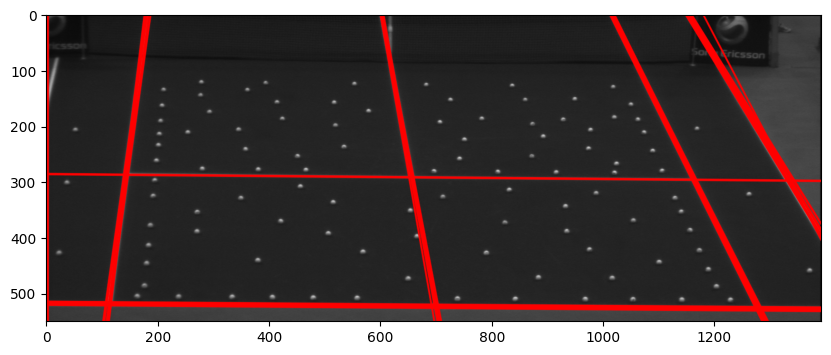

In [24]:
display_lines(img, hough_lines, cam_mat)

### Non-maximal suppresion (kinda) to get rid of duplicates

In [25]:
def nonmaximal_suppresion(lines, allowed_sin_dist, propagate_suppressed):
    selected_lines = pd.Series(data=True, index=hough_lines.index)

    for i in range(len(selected_lines)):
        line_i = hough_lines.loc[i]
        
        if not propagate_suppressed and not selected_lines.loc[i]:
            continue
        
        for j in range(i+1, len(selected_lines)):
            line_j = hough_lines.loc[j]
            if not selected_lines.loc[j]:
                continue

            cos_dist = np.dot(line_i.camera, line_j.camera)
            sin_dist = np.sqrt(1 - cos_dist*cos_dist)

            if sin_dist > allowed_sin_dist:
                continue
            selected_lines.loc[j] = False
            
    return lines[selected_lines].reset_index(drop=True)

In [26]:
hough_lines = nonmaximal_suppresion(hough_lines, deg2rad(2.), propagate_suppressed=True)
hough_lines

pt0_in_image          pt1_in_image  \
0   [330.0, 518.0, 1.0]  [1382.0, 527.0, 1.0]   
1   [158.0, 287.0, 1.0]  [1168.0, 296.0, 1.0]   
2    [1015.0, 0.0, 1.0]  [1272.0, 515.0, 1.0]   
3   [108.0, 523.0, 1.0]     [181.0, 0.0, 1.0]   
4    [1156.0, 3.0, 1.0]  [1389.0, 383.0, 1.0]   
5     [601.0, 0.0, 1.0]   [653.0, 282.0, 1.0]   
6     [3.0, 181.0, 1.0]     [3.0, 295.0, 1.0]   
7  [1274.0, 179.0, 1.0]  [1390.0, 400.0, 1.0]   

                                              camera  
0  [-0.00848693245042585, 0.9920281042053394, -0....  
1  [-0.008910204189149487, 0.9999229145601096, -0...  
2  [-0.8756372986851699, 0.4369685160428906, 0.20...  
3  [0.9531670453426951, 0.13304243653922893, 0.27...  
4  [-0.8219589348750076, 0.5039906100680965, 0.26...  
5  [-0.9831732127545558, 0.1812943512880744, -0.0...  
6   [-0.9418296585676967, 0.0, -0.33609060421597003]  
7  [-0.8511920221112896, 0.446779522918143, 0.275...

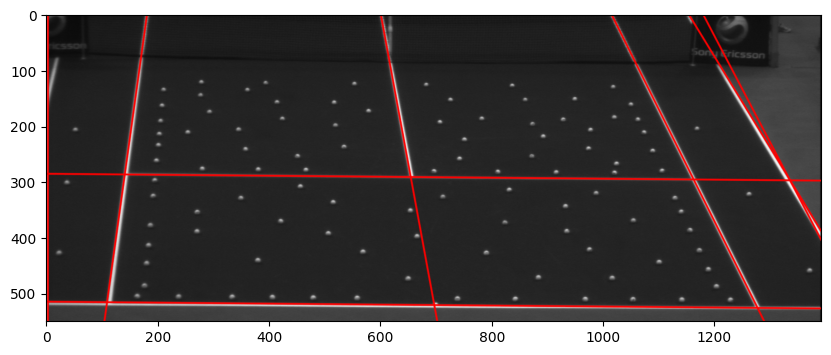

In [27]:
display_lines(img, hough_lines, cam_mat)

### Optimize line positions

In [28]:
optimized_coords = []

for _, line in hough_lines.iterrows():
    lsq_res = sp.optimize.least_squares(
        lambda line_in_camera: ((line_in_camera / np.linalg.norm(line_in_camera)).reshape(3, 1) * line_pixels_in_camera_normed).sum(axis=0),
        line.camera,
        loss='arctan',
        #bounds=([line.rho-50, line.theta-0.2], [line.rho+50, line.theta+0.2]),
        f_scale=deg2rad(0.3)
    )
    
    optimized_coords.append(lsq_res.x)
    
optimized_coords = [coords / np.linalg.norm(coords) for coords in optimized_coords]
    
hough_lines.camera = optimized_coords
hough_lines

pt0_in_image          pt1_in_image  \
0   [330.0, 518.0, 1.0]  [1382.0, 527.0, 1.0]   
1   [158.0, 287.0, 1.0]  [1168.0, 296.0, 1.0]   
2    [1015.0, 0.0, 1.0]  [1272.0, 515.0, 1.0]   
3   [108.0, 523.0, 1.0]     [181.0, 0.0, 1.0]   
4    [1156.0, 3.0, 1.0]  [1389.0, 383.0, 1.0]   
5     [601.0, 0.0, 1.0]   [653.0, 282.0, 1.0]   
6     [3.0, 181.0, 1.0]     [3.0, 295.0, 1.0]   
7  [1274.0, 179.0, 1.0]  [1390.0, 400.0, 1.0]   

                                              camera  
0  [-0.006023862765945584, 0.9919008750428724, -0...  
1  [-0.00865455726294458, 0.9999255800400829, -0....  
2  [-0.8743919974998962, 0.43949291730108936, 0.2...  
3  [0.9544039660041196, 0.12566265482332833, 0.27...  
4  [-0.8224543910838844, 0.5034034599420254, 0.26...  
5  [-0.9840415469439958, 0.17659800970941467, -0....  
6  [-0.9419878263911666, -0.010342898121063523, -...  
7  [-0.822455444431735, 0.5034011521278614, 0.264...

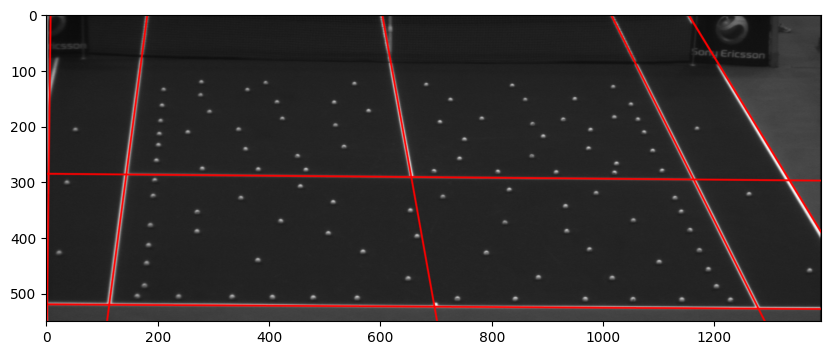

In [29]:
display_lines(img, hough_lines, cam_mat)

### And again remove duplicates (but with smaller distance)

In [30]:
hough_lines = nonmaximal_suppresion(hough_lines, deg2rad(0.5), propagate_suppressed=False)
hough_lines

pt0_in_image          pt1_in_image  \
0  [330.0, 518.0, 1.0]  [1382.0, 527.0, 1.0]   
1  [158.0, 287.0, 1.0]  [1168.0, 296.0, 1.0]   
2   [1015.0, 0.0, 1.0]  [1272.0, 515.0, 1.0]   
3  [108.0, 523.0, 1.0]     [181.0, 0.0, 1.0]   
4   [1156.0, 3.0, 1.0]  [1389.0, 383.0, 1.0]   
5    [601.0, 0.0, 1.0]   [653.0, 282.0, 1.0]   
6    [3.0, 181.0, 1.0]     [3.0, 295.0, 1.0]   

                                              camera  
0  [-0.006023862765945584, 0.9919008750428724, -0...  
1  [-0.00865455726294458, 0.9999255800400829, -0....  
2  [-0.8743919974998962, 0.43949291730108936, 0.2...  
3  [0.9544039660041196, 0.12566265482332833, 0.27...  
4  [-0.8224543910838844, 0.5034034599420254, 0.26...  
5  [-0.9840415469439958, 0.17659800970941467, -0....  
6  [-0.9419878263911666, -0.010342898121063523, -...

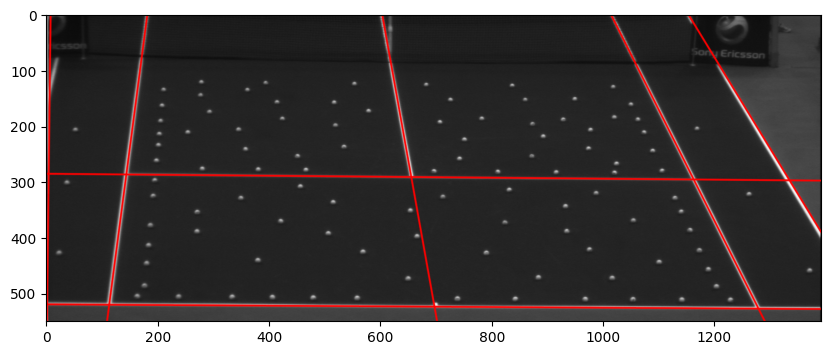

In [31]:
display_lines(img, hough_lines, cam_mat)

# Split lines into two orthogonal sets

In [32]:
hough_lines['group'] = 'X'
hough_lines

pt0_in_image          pt1_in_image  \
0  [330.0, 518.0, 1.0]  [1382.0, 527.0, 1.0]   
1  [158.0, 287.0, 1.0]  [1168.0, 296.0, 1.0]   
2   [1015.0, 0.0, 1.0]  [1272.0, 515.0, 1.0]   
3  [108.0, 523.0, 1.0]     [181.0, 0.0, 1.0]   
4   [1156.0, 3.0, 1.0]  [1389.0, 383.0, 1.0]   
5    [601.0, 0.0, 1.0]   [653.0, 282.0, 1.0]   
6    [3.0, 181.0, 1.0]     [3.0, 295.0, 1.0]   

                                              camera group  
0  [-0.006023862765945584, 0.9919008750428724, -0...     X  
1  [-0.00865455726294458, 0.9999255800400829, -0....     X  
2  [-0.8743919974998962, 0.43949291730108936, 0.2...     X  
3  [0.9544039660041196, 0.12566265482332833, 0.27...     X  
4  [-0.8224543910838844, 0.5034034599420254, 0.26...     X  
5  [-0.9840415469439958, 0.17659800970941467, -0....     X  
6  [-0.9419878263911666, -0.010342898121063523, -...     X

### Calculate intersections of all line pairs

In [33]:
intersections_index = pd.MultiIndex.from_product([hough_lines.index, hough_lines.index])
intersections_index = intersections_index[intersections_index.get_level_values(0) < intersections_index.get_level_values(1)]
intersections_index

intersections = pd.DataFrame(
    { "camera": [np.cross(hough_lines.loc[id0, 'camera'], hough_lines.loc[id1, 'camera']) for id0, id1 in intersections_index] },
    index=intersections_index,
)
intersections.camera /= intersections.camera.map(np.linalg.norm)
intersections

camera
0 1  [0.9997268247558948, 0.008838893124835748, 0.0...
  2  [0.28548508659890104, 0.12329933596379876, 0.9...
  3  [0.28555250097619833, -0.11988467163529495, -0...
  4  [0.37015271602146926, 0.1200734652969331, 0.92...
  5  [0.0007922002129743059, 0.12687845499175424, 0...
  6  [-0.33432390959893926, 0.11757526509191804, 0....
1 2  [0.23385694430526435, 0.01038422977971864, 0.9...
  3  [0.27365829324603536, -0.005902095321894347, -...
  4  [0.31254442295126117, 0.010872884579403105, 0....
  5  [-0.02064045804187626, 0.008418287191027437, 0...
  6  [-0.3355516909354736, 0.00519612179797214, 0.9...
2 3  [0.13498275558837888, 0.6273853821192675, -0.7...
  4  [0.12723568692260995, 0.6166394102518352, -0.7...
  5  [-0.12805968719265892, -0.6177881246124665, 0....
  6  [-0.21975003489244782, -0.7365206551332234, 0....
3 4  [-0.13557102802519524, -0.6256849541671491, 0....
  5  [-0.1312967289554312, -0.6379276562994671, 0.7...
  6  [-0.29698949045886114, 0.49138288170068634, 0....
4 5  [-0.12801084186004388, -0.6174851829861544, 0....
  6  [-0.226794589144062, -0.7172189354786831, 0.65...
5 6  [-0.1645980410164443, -0.8568544375824259, 0.4...

In [34]:
sin_dist_thr = deg2rad(2)
cos2_dist_thr = 1 - sin_dist_thr ** 2

### Find first group (A)

In [35]:
none_ids = hough_lines.index[hough_lines.group == 'X']
left_intersections = intersections[intersections.index.get_level_values(0).isin(none_ids) & intersections.index.get_level_values(1).isin(none_ids)].copy()
left_intersections

closest_cnt = []
intersecting_lines = []
for pt in left_intersections.camera:
    closest_mask = (np.column_stack(left_intersections.camera) * pt.reshape(3, 1)).sum(axis=0) ** 2 > cos2_dist_thr
    closest_cnt.append(np.count_nonzero(closest_mask))
    closest_index = left_intersections[closest_mask].index
    closest_lines_ids = closest_index.get_level_values(0).append(closest_index.get_level_values(1)).unique().values
    intersecting_lines.append(closest_lines_ids)
    
left_intersections['closest_cnt'] = closest_cnt
left_intersections['intersecting_lines'] = intersecting_lines

left_intersections

camera  closest_cnt  \
0 1  [0.9997268247558948, 0.008838893124835748, 0.0...            1   
  2  [0.28548508659890104, 0.12329933596379876, 0.9...            1   
  3  [0.28555250097619833, -0.11988467163529495, -0...            1   
  4  [0.37015271602146926, 0.1200734652969331, 0.92...            1   
  5  [0.0007922002129743059, 0.12687845499175424, 0...            1   
  6  [-0.33432390959893926, 0.11757526509191804, 0....            1   
1 2  [0.23385694430526435, 0.01038422977971864, 0.9...            1   
  3  [0.27365829324603536, -0.005902095321894347, -...            1   
  4  [0.31254442295126117, 0.010872884579403105, 0....            1   
  5  [-0.02064045804187626, 0.008418287191027437, 0...            1   
  6  [-0.3355516909354736, 0.00519612179797214, 0.9...            1   
2 3  [0.13498275558837888, 0.6273853821192675, -0.7...            6   
  4  [0.12723568692260995, 0.6166394102518352, -0.7...            6   
  5  [-0.12805968719265892, -0.6177881246124665, 0....            6   
  6  [-0.21975003489244782, -0.7365206551332234, 0....            2   
3 4  [-0.13557102802519524, -0.6256849541671491, 0....            6   
  5  [-0.1312967289554312, -0.6379276562994671, 0.7...            6   
  6  [-0.29698949045886114, 0.49138288170068634, 0....            1   
4 5  [-0.12801084186004388, -0.6174851829861544, 0....            6   
  6  [-0.226794589144062, -0.7172189354786831, 0.65...            2   
5 6  [-0.1645980410164443, -0.8568544375824259, 0.4...            1   

    intersecting_lines  
0 1             [0, 1]  
  2             [0, 2]  
  3             [0, 3]  
  4             [0, 4]  
  5             [0, 5]  
  6             [0, 6]  
1 2             [1, 2]  
  3             [1, 3]  
  4             [1, 4]  
  5             [1, 5]  
  6             [1, 6]  
2 3       [2, 3, 4, 5]  
  4       [2, 3, 4, 5]  
  5       [2, 3, 4, 5]  
  6          [2, 4, 6]  
3 4       [2, 3, 4, 5]  
  5       [2, 3, 4, 5]  
  6             [3, 6]  
4 5       [2, 3, 4, 5]  
  6          [2, 4, 6]  
5 6             [5, 6]

In [36]:
ideal_point_A = left_intersections.loc[left_intersections.closest_cnt.idxmax()].camera
group_ids = left_intersections.loc[left_intersections.closest_cnt.idxmax()].intersecting_lines
hough_lines.loc[hough_lines.index.isin(group_ids), 'group'] = 'A'
hough_lines

pt0_in_image          pt1_in_image  \
0  [330.0, 518.0, 1.0]  [1382.0, 527.0, 1.0]   
1  [158.0, 287.0, 1.0]  [1168.0, 296.0, 1.0]   
2   [1015.0, 0.0, 1.0]  [1272.0, 515.0, 1.0]   
3  [108.0, 523.0, 1.0]     [181.0, 0.0, 1.0]   
4   [1156.0, 3.0, 1.0]  [1389.0, 383.0, 1.0]   
5    [601.0, 0.0, 1.0]   [653.0, 282.0, 1.0]   
6    [3.0, 181.0, 1.0]     [3.0, 295.0, 1.0]   

                                              camera group  
0  [-0.006023862765945584, 0.9919008750428724, -0...     X  
1  [-0.00865455726294458, 0.9999255800400829, -0....     X  
2  [-0.8743919974998962, 0.43949291730108936, 0.2...     A  
3  [0.9544039660041196, 0.12566265482332833, 0.27...     A  
4  [-0.8224543910838844, 0.5034034599420254, 0.26...     A  
5  [-0.9840415469439958, 0.17659800970941467, -0....     A  
6  [-0.9419878263911666, -0.010342898121063523, -...     X

### Find second group (B)
The code is duplicated to see the intermediate results

In [37]:
none_ids = hough_lines.index[hough_lines.group == 'X']
left_intersections = intersections[intersections.index.get_level_values(0).isin(none_ids) & intersections.index.get_level_values(1).isin(none_ids)].copy()
left_intersections

closest_cnt = []
intersecting_lines = []
for pt in left_intersections.camera:
    closest_mask = (np.column_stack(left_intersections.camera) * pt.reshape(3, 1)).sum(axis=0) ** 2 > cos2_dist_thr
    closest_cnt.append(np.count_nonzero(closest_mask))
    closest_index = left_intersections[closest_mask].index
    closest_lines_ids = closest_index.get_level_values(0).append(closest_index.get_level_values(1)).unique().values
    intersecting_lines.append(closest_lines_ids)
    
left_intersections['closest_cnt'] = closest_cnt
left_intersections['intersecting_lines'] = intersecting_lines

left_intersections

camera  closest_cnt  \
0 1  [0.9997268247558948, 0.008838893124835748, 0.0...            1   
  6  [-0.33432390959893926, 0.11757526509191804, 0....            1   
1 6  [-0.3355516909354736, 0.00519612179797214, 0.9...            1   

    intersecting_lines  
0 1             [0, 1]  
  6             [0, 6]  
1 6             [1, 6]

If there are no three lines left that intersect in the same point, take all the remaining lines into group B.

In [38]:
if left_intersections.closest_cnt.max() == 1:
    hough_lines.loc[hough_lines.group == 'X', 'group'] = 'B'
group_ids = left_intersections.loc[left_intersections.closest_cnt.idxmax()].intersecting_lines
hough_lines.loc[hough_lines.index.isin(group_ids), 'group'] = 'B'
hough_lines

pt0_in_image          pt1_in_image  \
0  [330.0, 518.0, 1.0]  [1382.0, 527.0, 1.0]   
1  [158.0, 287.0, 1.0]  [1168.0, 296.0, 1.0]   
2   [1015.0, 0.0, 1.0]  [1272.0, 515.0, 1.0]   
3  [108.0, 523.0, 1.0]     [181.0, 0.0, 1.0]   
4   [1156.0, 3.0, 1.0]  [1389.0, 383.0, 1.0]   
5    [601.0, 0.0, 1.0]   [653.0, 282.0, 1.0]   
6    [3.0, 181.0, 1.0]     [3.0, 295.0, 1.0]   

                                              camera group  
0  [-0.006023862765945584, 0.9919008750428724, -0...     B  
1  [-0.00865455726294458, 0.9999255800400829, -0....     B  
2  [-0.8743919974998962, 0.43949291730108936, 0.2...     A  
3  [0.9544039660041196, 0.12566265482332833, 0.27...     A  
4  [-0.8224543910838844, 0.5034034599420254, 0.26...     A  
5  [-0.9840415469439958, 0.17659800970941467, -0....     A  
6  [-0.9419878263911666, -0.010342898121063523, -...     B

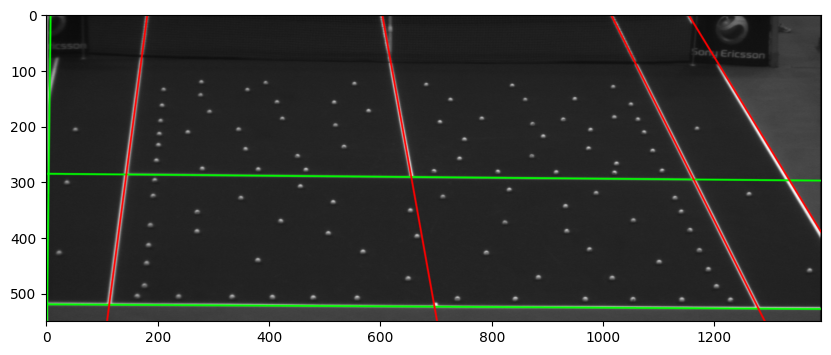

In [39]:
group_colors = {'A': (255, 0, 0), 'B': (0, 255, 0), 'X': (0, 0, 255)}
display_lines(img, hough_lines, cam_mat, color = lambda idx: group_colors[hough_lines.group[idx]])

# Model the tennis court

As all the dimension of a tennis court are in feet and inches and since one feet is 12 inches, I'll use an inch as a unit here. I'll also assume that the line thichness is equal to 2 inches for all of the lines.

I'll prepare an image with all the lines drawn where 1px = 1in. Also some lines are gonna be centered, some not - everything according to the court specs. The image is gonna have 1ft = 12px margins.

Note: those "halves" that you can see below, are because according to OpenCV, the (0, 0) point is in the middle of the top-left pixel.

In [40]:
court_img = np.zeros((12*(78+2), 12*(36+2), 3), np.uint8)
# plt.imshow(court_image)

In [41]:
def draw_court_line(canvas, pt0, pt1, color=(255, 255, 255)):
    #adjust the points
    cv.rectangle(canvas, tuple((pt0 - 0.5).astype(int)), tuple((pt1 + 0.5).astype(int)), color)

### Specify the lines

In [42]:
model_lines = []

In [43]:
# Baselines
model_lines.append({
    'name': 'baseline0',
    'pt0': np.array([ 1*12 + 0.5, 1*12 + 0.5]),
    'pt1': np.array([37*12 - 1.5, 1*12 + 0.5]),
    'group': 'H'
})
model_lines.append({
    'name': 'baseline1',
    'pt0': np.array([ 1*12 + 0.5, 79*12 - 1.5]),
    'pt1': np.array([37*12 - 1.5, 79*12 - 1.5]),
    'group': 'H'
})

draw_court_line(court_img, model_lines[-2]['pt0'], model_lines[-2]['pt1'], (243, 255, 185))
draw_court_line(court_img, model_lines[-1]['pt0'], model_lines[-1]['pt1'], (247, 153, 110))
# plt.imshow(court_image)

In [44]:
# Don't model net as it is not drawn on a court

# Net (centered)
# model_lines.append({
#     'name': 'net',
#     'pt0': np.array([ 1*12 + 0.5, 40*12 - 0.5]),
#     'pt1': np.array([37*12 - 1.5, 40*12 - 0.5]),
#     'group': 'H',
#     'order': 2
# })

# draw_court_line(court_img, model_lines[-1]['pt0'], model_lines[-1]['pt1'], (219, 48, 105))
# plt.imshow(court_image)

In [45]:
# Service lines (centered)
model_lines.append({
    'name': 'service_line0',
    'pt0': np.array([ 5.5*12 + 0.5, 19*12 - 0.5]),
    'pt1': np.array([32.5*12 - 1.5, 19*12 - 0.5]),
    'group': 'H'
})
model_lines.append({
    'name': 'service_line1',
    'pt0': np.array([ 5.5*12 + 0.5, 61*12 - 0.5]),
    'pt1': np.array([32.5*12 - 1.5, 61*12 - 0.5]),
    'group': 'H'
})

draw_court_line(court_img, model_lines[-2]['pt0'], model_lines[-2]['pt1'], (101, 222, 241))
draw_court_line(court_img, model_lines[-1]['pt0'], model_lines[-1]['pt1'], (239, 171, 255 ))
# plt.imshow(court_image)

In [46]:
# Doubles sidelines
model_lines.append({
    'name': 'doubles_sideline0',
    'pt0': np.array([1*12 + 0.5,  1*12 + 0.5]),
    'pt1': np.array([1*12 + 0.5, 79*12 - 1.5]),
    'group': 'V'
})
model_lines.append({
    'name': 'doubles_sideline1',
    'pt0': np.array([37*12 - 1.5,  1*12 + 0.5]),
    'pt1': np.array([37*12 - 1.5, 79*12 - 1.5]),
    'group': 'V'
})

draw_court_line(court_img, model_lines[-2]['pt0'], model_lines[-2]['pt1'], (217, 187, 249))
draw_court_line(court_img, model_lines[-1]['pt0'], model_lines[-1]['pt1'], (217, 187, 249))
# plt.imshow(court_image)

In [47]:
# Singles sidelines
model_lines.append({
    'name': 'singles_sideline0',
    'pt0': np.array([5.5*12 + 0.5,  1*12 + 0.5]),
    'pt1': np.array([5.5*12 + 0.5, 79*12 - 1.5]),
    'group': 'V'
})
model_lines.append({
    'name': 'singles_sideline1',
    'pt0': np.array([32.5*12 - 1.5,  1*12 + 0.5]),
    'pt1': np.array([32.5*12 - 1.5, 79*12 - 1.5]),
    'group': 'V'
})

draw_court_line(court_img, model_lines[-2]['pt0'], model_lines[-2]['pt1'], (70, 129, 137))
draw_court_line(court_img, model_lines[-1]['pt0'], model_lines[-1]['pt1'], (115, 104, 59))
# plt.imshow(court_image)

In [48]:
# Center service line
model_lines.append({
    'name': 'center_service_line',
    'pt0': np.array([19*12 - 0.5, 19*12 - 0.5]),
    'pt1': np.array([19*12 - 0.5, 61*12 - 0.5]),
    'group': 'V'
})

draw_court_line(court_img, model_lines[-1]['pt0'], model_lines[-1]['pt1'], (247, 236, 89))
# plt.imshow(court_image)

In [49]:
model_lines = pd.DataFrame(model_lines)
model_lines

name             pt0             pt1 group
0            baseline0    [12.5, 12.5]   [442.5, 12.5]     H
1            baseline1   [12.5, 946.5]  [442.5, 946.5]     H
2        service_line0   [66.5, 227.5]  [388.5, 227.5]     H
3        service_line1   [66.5, 731.5]  [388.5, 731.5]     H
4    doubles_sideline0    [12.5, 12.5]   [12.5, 946.5]     V
5    doubles_sideline1   [442.5, 12.5]  [442.5, 946.5]     V
6    singles_sideline0    [66.5, 12.5]   [66.5, 946.5]     V
7    singles_sideline1   [388.5, 12.5]  [388.5, 946.5]     V
8  center_service_line  [227.5, 227.5]  [227.5, 731.5]     V

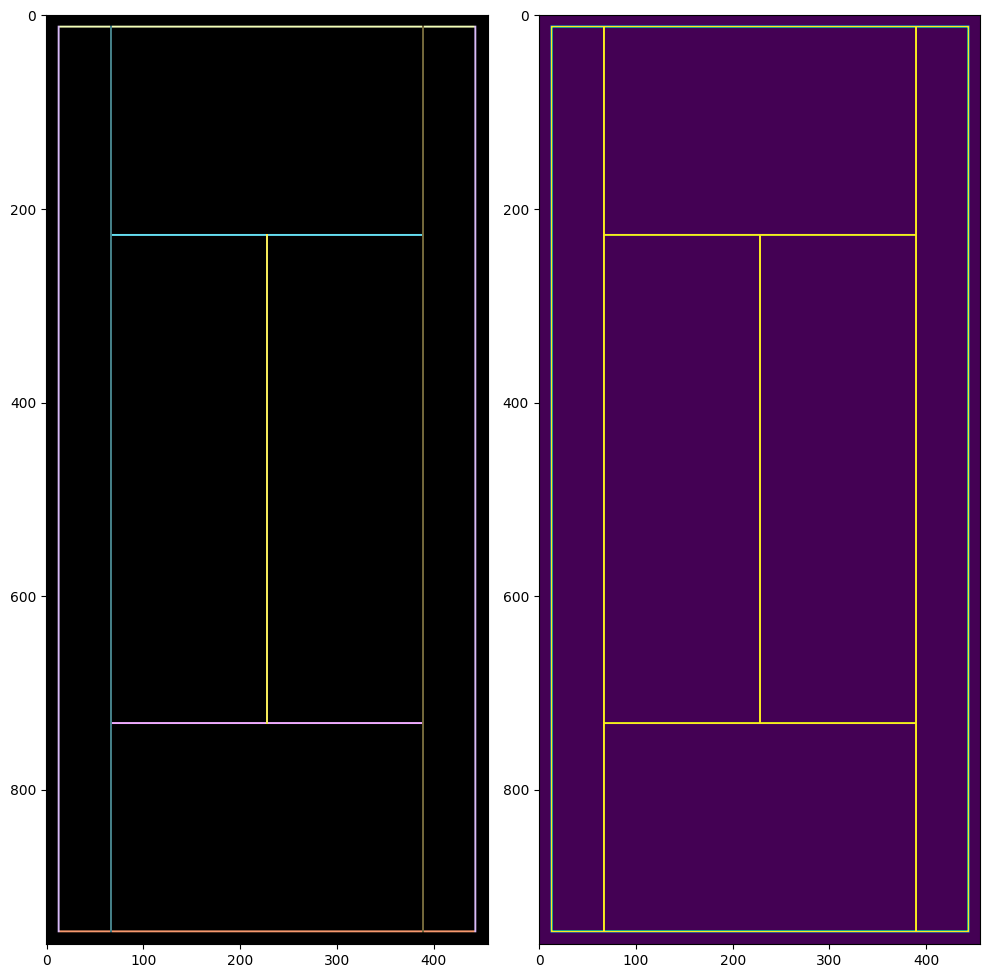

In [50]:
court_image_mono = np.zeros((12*(78+2), 12*(36+2)), np.uint8)
model_lines.apply(lambda line: draw_court_line(court_image_mono, line['pt0'], line['pt1'], 1), axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), tight_layout=True)
ax1.imshow(court_img)
ax2.imshow(court_image_mono)
plt.show()

### Calculate the model line coordinates in the homogenous space

In [51]:
pt0_in_camera = [np.array([pt[0], pt[1], 1.]) for pt in model_lines.pt0]
pt1_in_camera = [np.array([pt[0], pt[1], 1.]) for pt in model_lines.pt1]

model_lines['camera'] = [np.cross(pt0, pt1) for pt0, pt1 in zip(pt0_in_camera, pt1_in_camera)]
model_lines['camera'] = [pt / np.linalg.norm(pt) for pt in model_lines.camera]
model_lines

name             pt0             pt1 group  \
0            baseline0    [12.5, 12.5]   [442.5, 12.5]     H   
1            baseline1   [12.5, 946.5]  [442.5, 946.5]     H   
2        service_line0   [66.5, 227.5]  [388.5, 227.5]     H   
3        service_line1   [66.5, 731.5]  [388.5, 731.5]     H   
4    doubles_sideline0    [12.5, 12.5]   [12.5, 946.5]     V   
5    doubles_sideline1   [442.5, 12.5]  [442.5, 946.5]     V   
6    singles_sideline0    [66.5, 12.5]   [66.5, 946.5]     V   
7    singles_sideline1   [388.5, 12.5]  [388.5, 946.5]     V   
8  center_service_line  [227.5, 227.5]  [227.5, 731.5]     V   

                                              camera  
0    [0.0, 0.07974522228289001, -0.9968152785361251]  
1  [0.0, 0.0010565234462535109, -0.9999994418789481]  
2   [0.0, 0.004395561931740612, -0.9999903394709893]  
3   [0.0, 0.001367052721234439, -0.9999990655829921]  
4    [-0.07974522228289001, 0.0, 0.9968152785361251]  
5  [-0.0022598812349494727, 0.0, 0.9999974464651418]  
6   [-0.015035894053464213, 0.0, 0.9998869545553702]  
7   [-0.002573994047031752, 0.0, 0.9999966872718358]  
8   [-0.004395561931740612, 0.0, 0.9999903394709893]

# Model matching - RANSAC style

In [52]:
def display_alignment(cam_img, model_img, model2camera_hom):
    canvas = cv.cvtColor(cam_img, cv.COLOR_GRAY2RGB)
    warped_model = cv.warpPerspective(model_img, model2camera_hom, cam_img.shape[::-1])
    warped_model_mono = cv.cvtColor(warped_model, cv.COLOR_RGB2GRAY);
    
    canvas = (255 - warped_model_mono[:,:,np.newaxis]) / 255.0 * canvas + warped_model_mono[:,:,np.newaxis] / 255.0 * warped_model
    canvas = canvas.astype(np.uint8)
    
    plt.figure(figsize=(20, 10))
    plt.imshow(canvas)
    plt.show()

In [53]:
def getWarpedModel(model2camera_hom):
    canvas = np.zeros(img.shape, dtype=np.uint8)
    pts0 = model2camera_hom @ np.vstack([np.column_stack(model_lines.pt0), np.ones(len(model_lines))])
    pts1 = model2camera_hom @ np.vstack([np.column_stack(model_lines.pt1), np.ones(len(model_lines))])
    pts0 = pts0[:2] / pts0[2:]
    pts1 = pts1[:2] / pts1[2:]

    pts0 = np.hsplit(pts0, len(model_lines))
    pts1 = np.hsplit(pts1, len(model_lines))

    for pt0, pt1 in zip(pts0, pts1):
        cv.line(canvas, pt0.reshape(-1).astype(int), pt1.reshape(-1).astype(int), 1)
        
    return canvas

### Homography generation procedure

Draw random 2 lines from each group A, B (image) and H, V (model) and decide which two groups are going to be matched.

In [54]:
gen = Generator(MT19937())

A_group = hough_lines.loc[hough_lines.group == 'A']
B_group = hough_lines.loc[hough_lines.group == 'B']
V_group = model_lines.loc[model_lines.group == 'V']
H_group = model_lines.loc[model_lines.group == 'H']

In [55]:
def generate_homography_candidate():
    A_ids = gen.choice(A_group.index, 2, replace=False)
    B_ids = gen.choice(B_group.index, 2, replace=False)
    V_ids = gen.choice(V_group.index, 2, replace=False)
    H_ids = gen.choice(H_group.index, 2, replace=False)
    AV_matching = bool(gen.integers(2))

    # if AV_matching:
    #     print ("A - V:", A_ids, V_ids)
    #     print ("B - H:", B_ids, H_ids)
    # else:
    #     print ("A - H:", A_ids, H_ids)
    #     print ("B - V:", B_ids, V_ids)
    
    A_sample = A_group.loc[A_ids]
    B_sample = B_group.loc[B_ids]
    V_sample = V_group.loc[V_ids]
    H_sample = H_group.loc[H_ids]

    src_lines = pd.concat([V_sample.camera, H_sample.camera]) if AV_matching else pd.concat([H_sample.camera, V_sample.camera])
    dst_lines = pd.concat([A_sample.camera, B_sample.camera])

    src_lines = np.column_stack(src_lines)
    src_lines /= src_lines[2,:]
    dst_lines = np.column_stack(dst_lines)
    dst_lines /= dst_lines[2,:]

    H, _ = cv.findHomography(src_lines[:2].T, dst_lines[:2].T, 0) # use all the lines 

    model2cam_homography = np.linalg.inv(H.T)
    
    return model2cam_homography

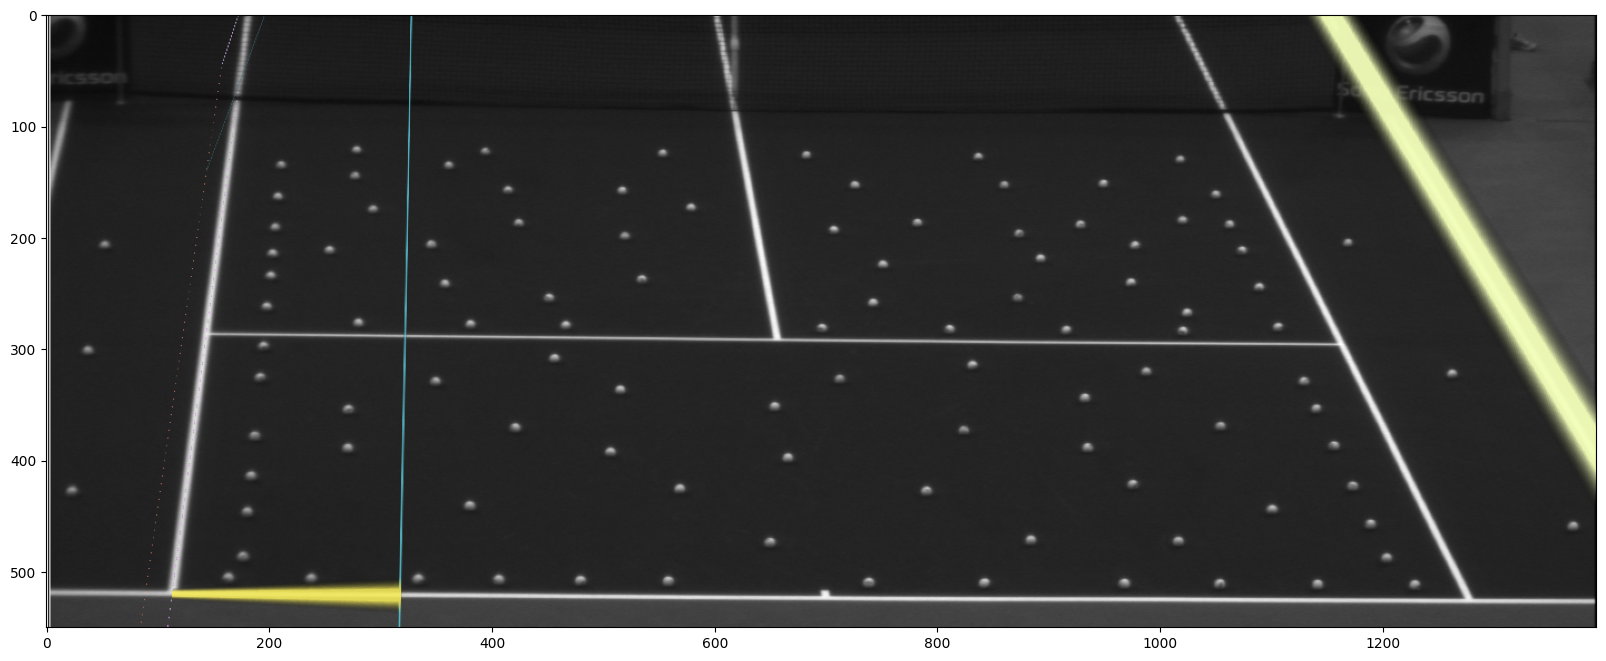

In [56]:
model2cam_homography = generate_homography_candidate()
display_alignment(img, court_img, cam_mat @ model2cam_homography)

### Homography evaluation procedures (first step) - exclude homographies with non-isotropic scaling

In [57]:
def nonisotropic_scaling_test(model2cam):
    H = cam_mat @ model2cam
    cx, cy = img.shape[1] / 2, img.shape[0] / 2
    quasi_inv_cam_mat = np.array([
        [1.0, 0., -cx],
        [0., 1.0, -cy],
        [0., 0., 1.]
    ])
    H1 = quasi_inv_cam_mat @ H
    f2 = -(H1[0,0] * H1[0,1] + H1[1,0] * H1[1,1]) / (H1[2,0] * H1[2,1])
    if f2 < 0:
        return (False, np.nan, np.nan)
    
    beta2 = (H1[0, 1]**2 + H1[1, 1]**2 + f2 * H1[2, 1]**2) / (H1[0, 0]**2 + H1[1, 0]**2 + f2 * H1[2, 0]**2)
    if beta2 < 0:
        return (False, np.nan, np.nan)
    
    beta = np.sqrt(beta2)
    return (beta > 0.75 and beta < 1.5, beta, np.sqrt(f2))

def nonisotropic_scaling_test2(model2cam):
    H1 = model2cam
    beta2 = np.dot(H1[:,1], H1[:,1]) / np.dot(H1[:,0], H1[:,0])
    beta = np.sqrt(beta2)
    
    return (beta > 0.4 and beta < 2.5, beta, 1.0)

In [58]:
nonisotropic_scaling_test(model2cam_homography), nonisotropic_scaling_test2(model2cam_homography)

((False, 0.30848801325275566, 385.05115282615554),
 (True, 0.5075642500388383, 1.0))

### Homography evaluation procedures (second step) - project model onto camera image and count line pixels that are covered and uncovered by the model

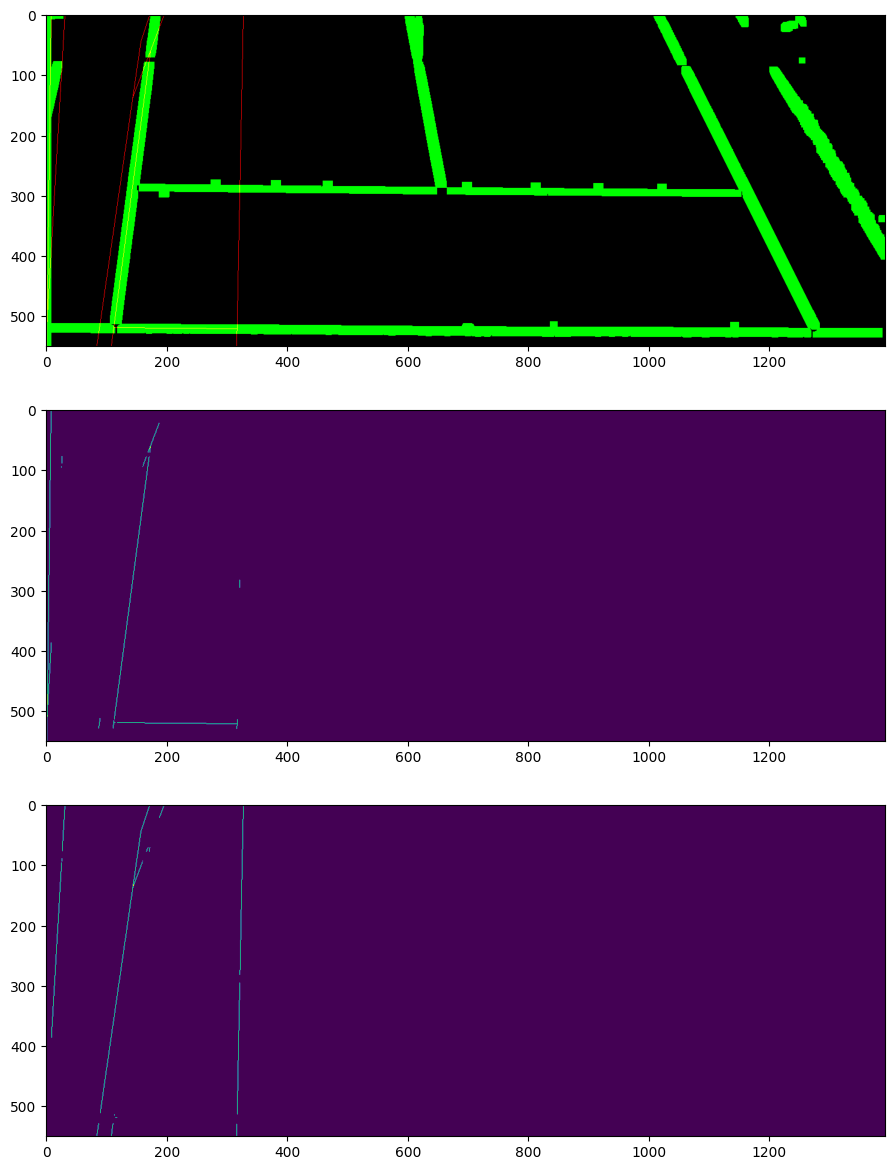

In [59]:
line_pixels_dilated = cv.dilate(line_pixels_img, np.ones((line_width, line_width)))

warped_model = getWarpedModel(cam_mat @ model2cam_homography)

model_pixels_on_court_line = warped_model.astype(bool) & line_pixels_dilated.astype(bool)
model_pixels_not_on_court_line = warped_model.astype(bool) & ~line_pixels_dilated.astype(bool)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 12), tight_layout=True)
ax1.imshow(np.dstack([warped_model, line_pixels_dilated, np.zeros(line_pixels_img.shape)]))
ax2.imshow(model_pixels_on_court_line)
ax3.imshow(model_pixels_not_on_court_line)
plt.show()

In [60]:
def coverage_test(model2cam):
    warped_model = getWarpedModel(cam_mat @ model2cam_homography)
    
    model_pixels_on_court_line = warped_model.astype(bool) & line_pixels_dilated.astype(bool)
    model_pixels_not_on_court_line = warped_model.astype(bool) & ~line_pixels_dilated.astype(bool)
    
    score = 1. * np.count_nonzero(model_pixels_on_court_line) - 0.75 * np.count_nonzero(model_pixels_not_on_court_line)
    
    return score

In [61]:
coverage_test(model2cam_homography)

300.0

### Put it into the loop

Best score: 0 0.8841144618699878 1230.25


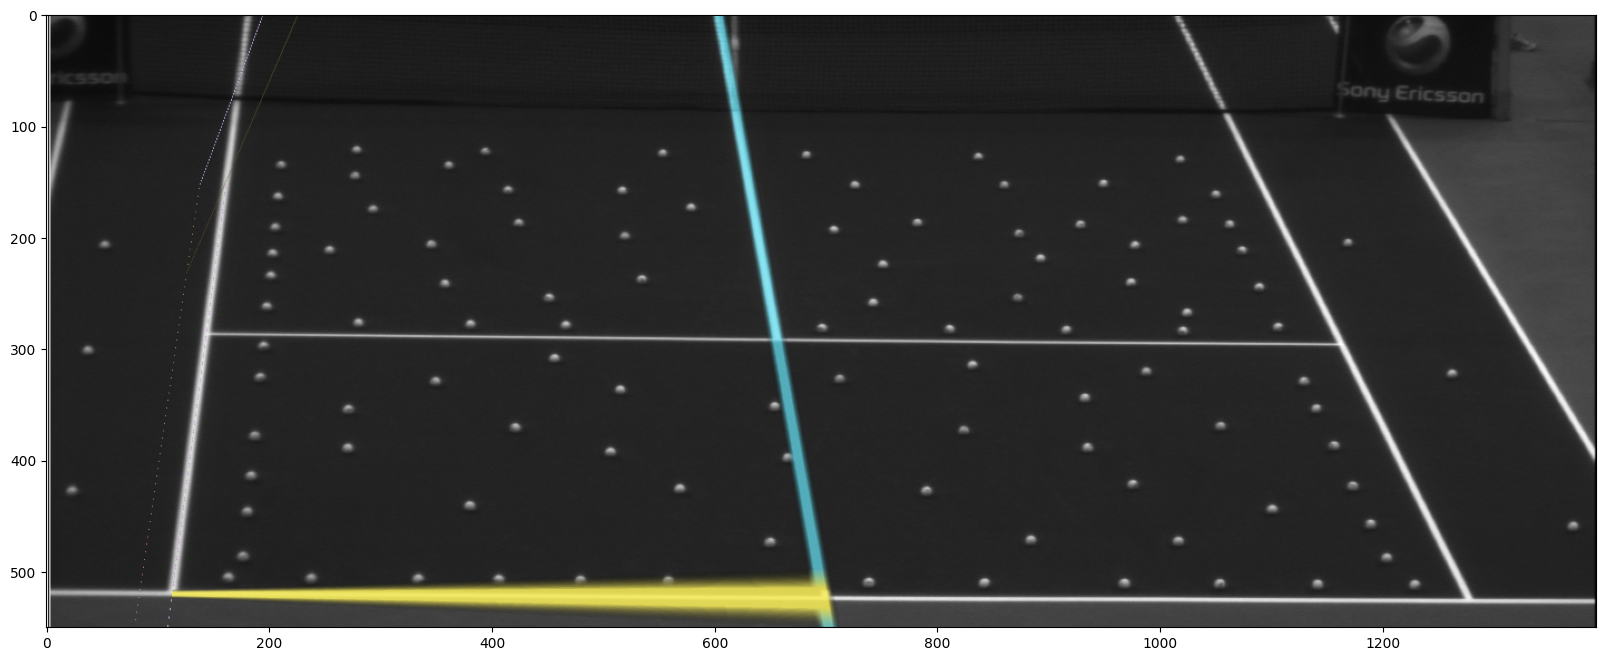

Best score: 15 1.039950846670521 1831.75


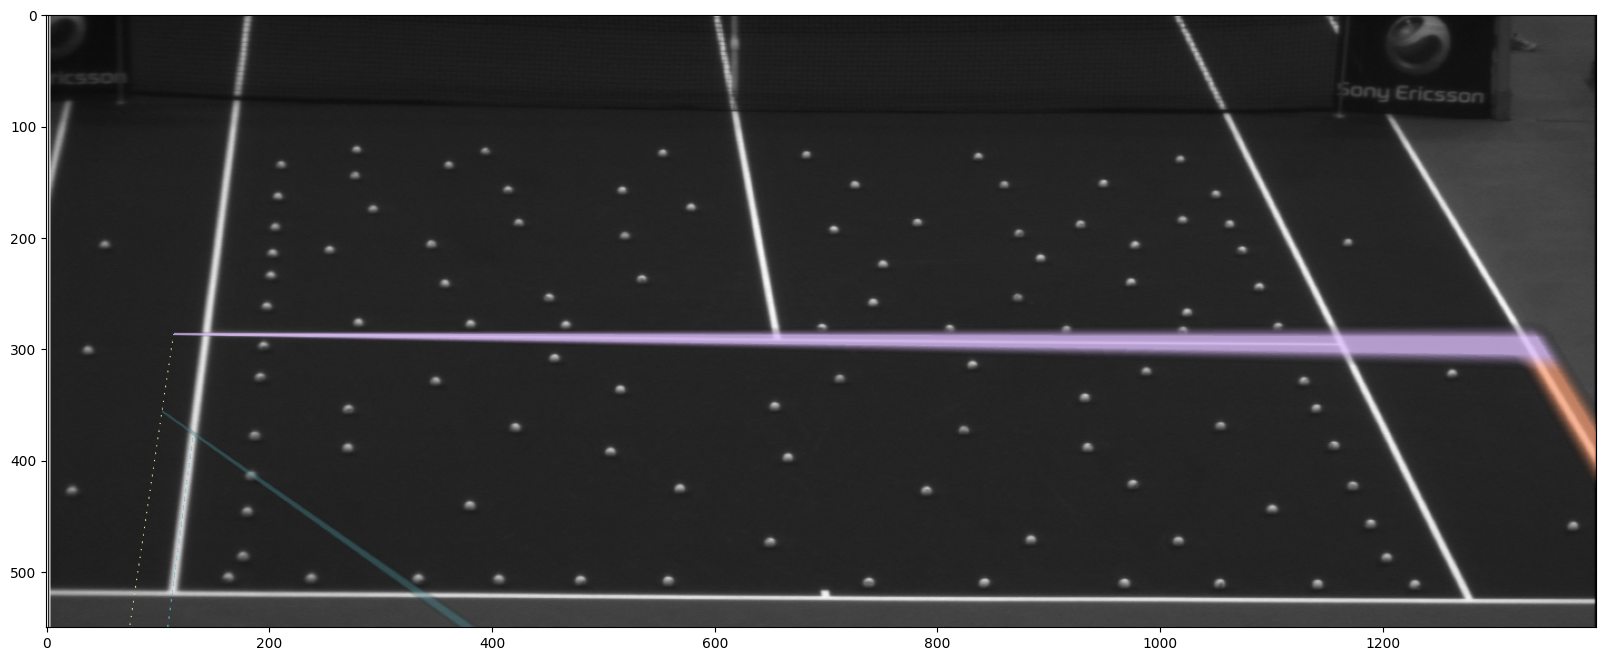

Best score: 24 0.53711421915488 1919.25


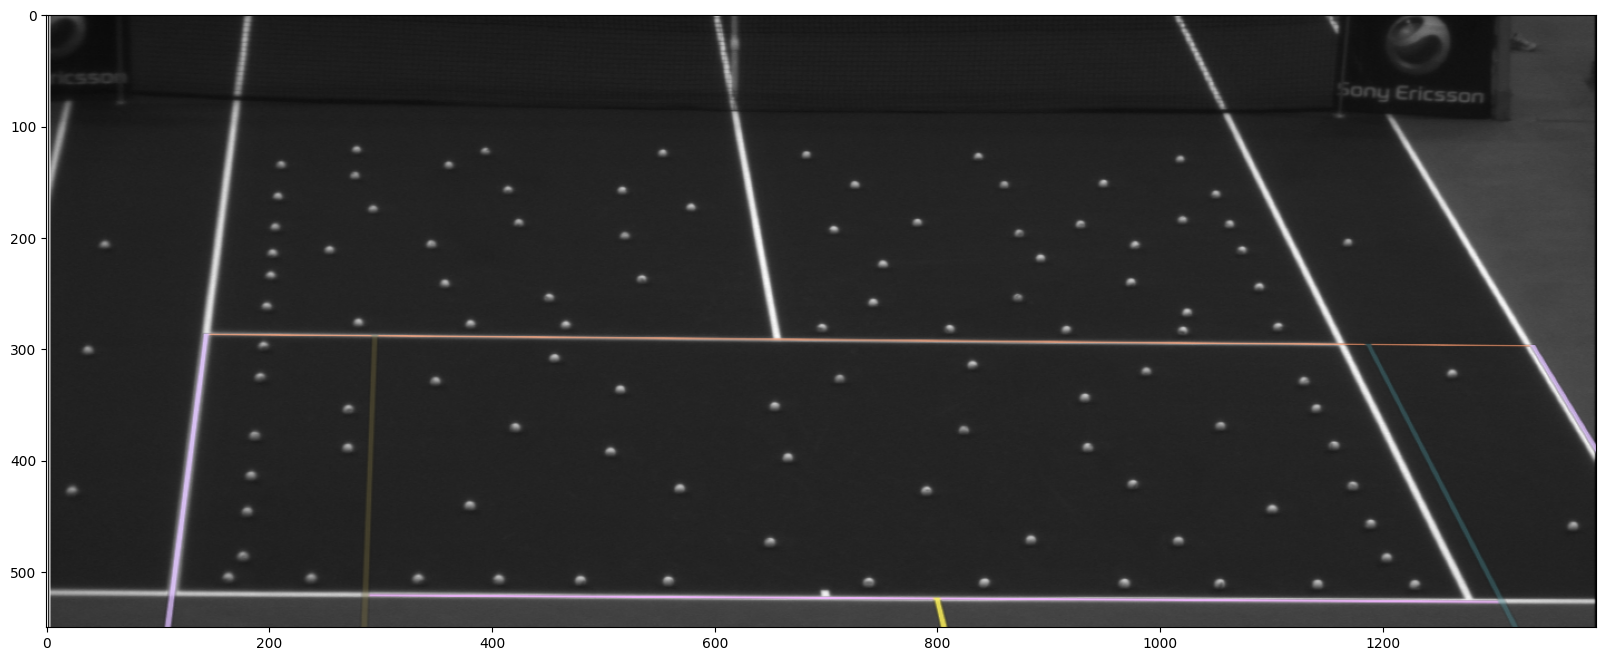

Best score: 29 0.40528058823949514 2940.75


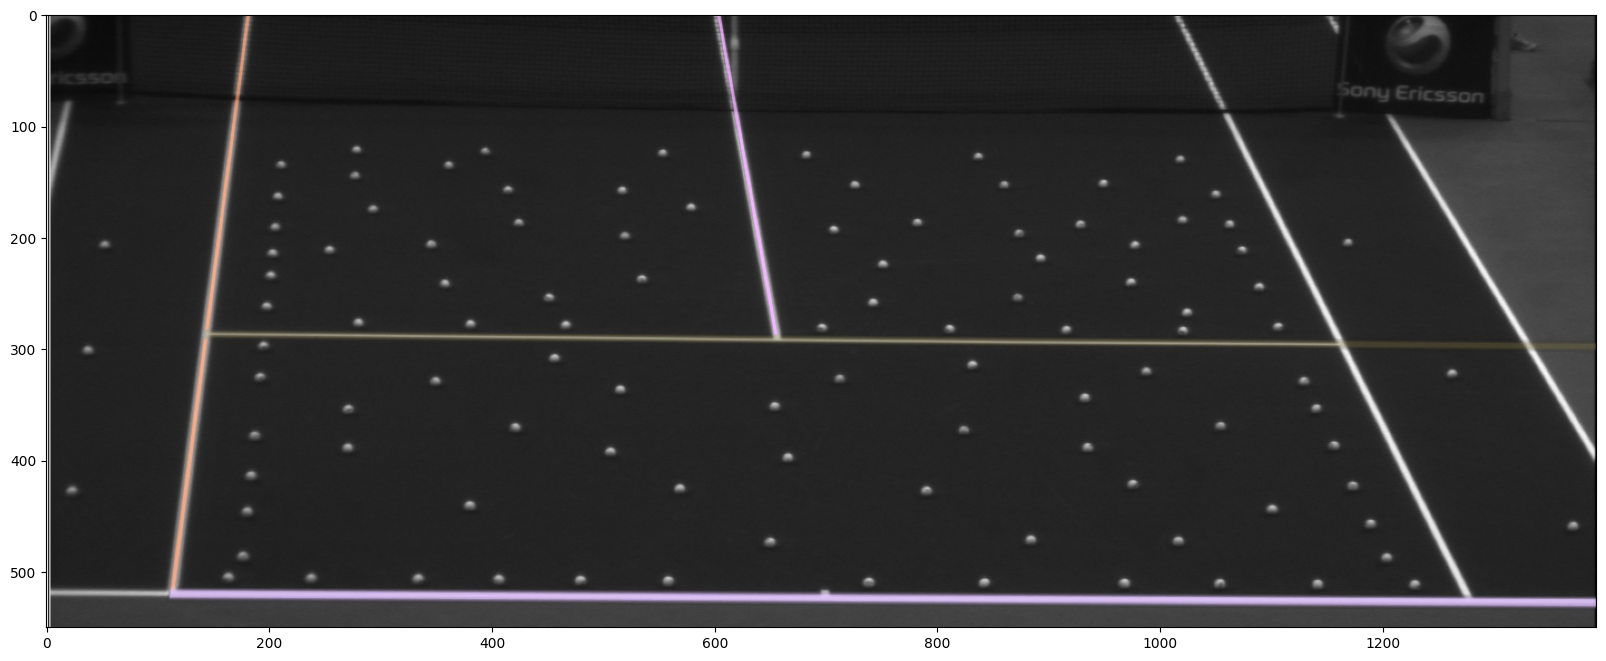

Best score: 42 0.4751757900525967 3992.25


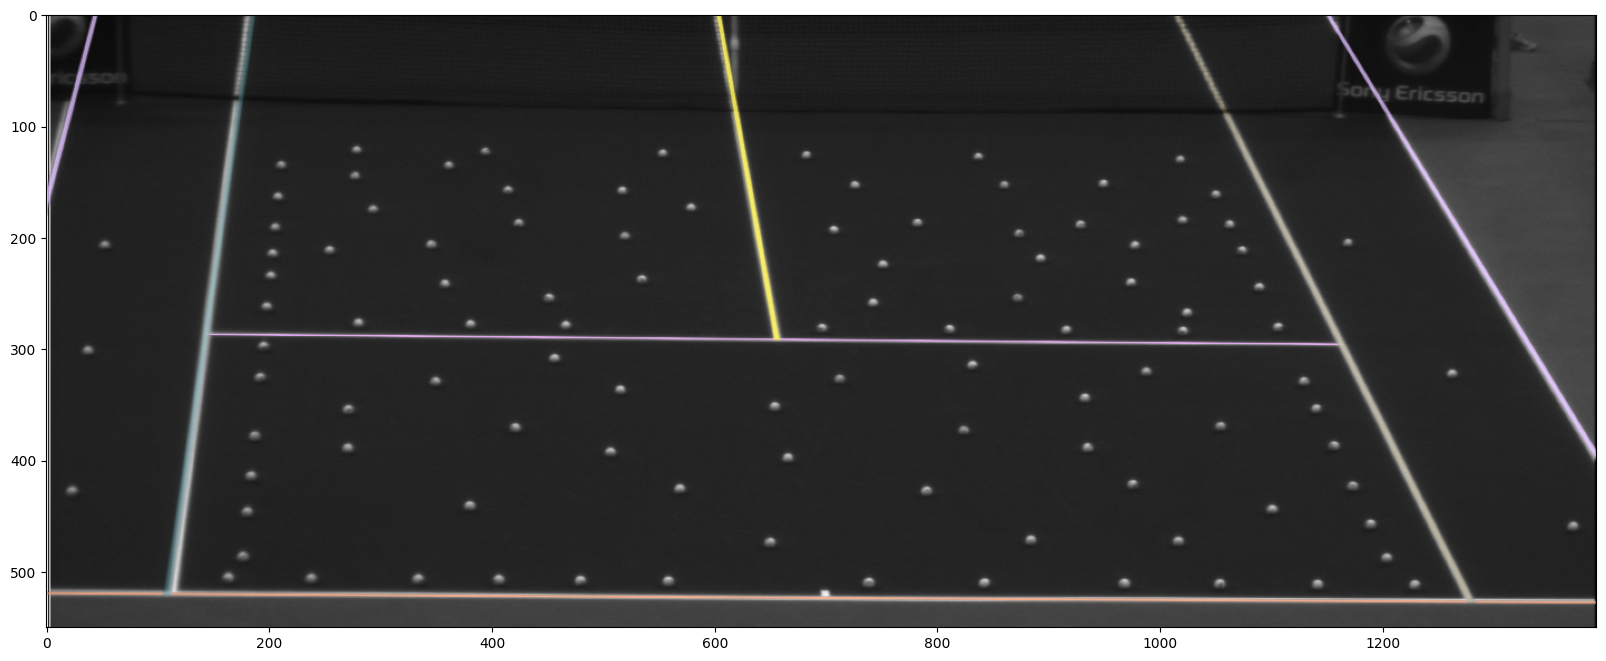

In [62]:
best_score = -np.inf
best_model2cam = None

for i in range(10000):
    model2cam_homography = generate_homography_candidate()
    passed, beta, f = nonisotropic_scaling_test2(model2cam_homography)
    if not passed:
        continue
    
    score = coverage_test(model2cam_homography)
    if score > best_score:
        best_model2cam = model2cam_homography
        best_score = score
        print ("Best score:", i, beta, best_score)
        display_alignment(img, court_img, cam_mat @ best_model2cam)

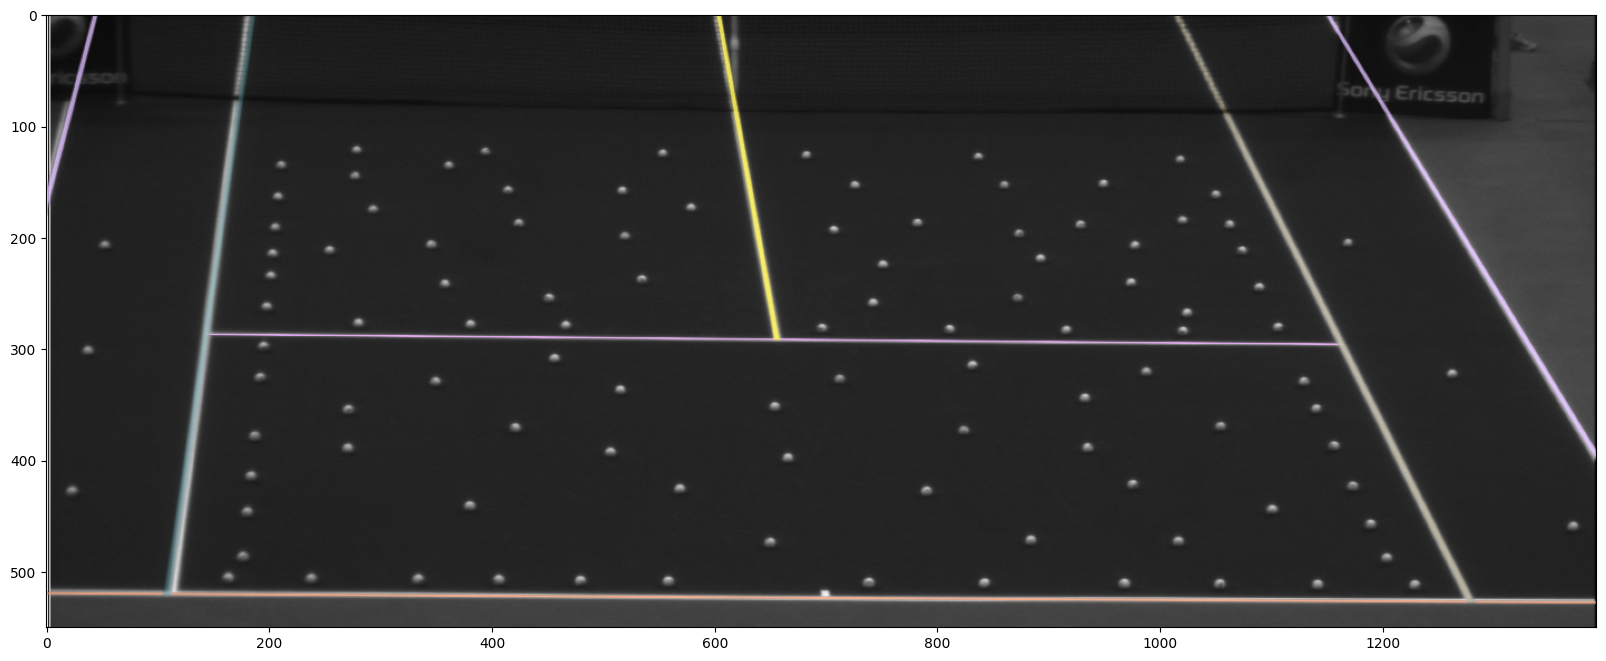

In [63]:
if best_model2cam is not None:
    display_alignment(img, court_img, cam_mat @ best_model2cam)